<a href="https://colab.research.google.com/github/BenRodriguez1029/bayesflow-model-comparison/blob/main/simple_classification_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras.utils import Sequence
from keras.layers import Layer, Dense, GlobalAveragePooling1D, Reshape
from keras.initializers import RandomNormal
from keras.models import Sequential
import keras.ops as ops

import numpy as np
import bayesflow as bf
import random
import tensorflow as tf

from losses import logistic_loss, exponential_loss, alpha_log_exponential_loss, cross_entropy_loss

print(keras.backend.backend())

jax


### Simulator and Data Preparation

In [81]:
# create model simulators

def prior_alternative():
    return np.random.normal(loc=0, scale=1)

def sample_model_0(sample_size, n=30):
    samples = np.random.normal(loc=0, scale=1, size=(sample_size, n))
    return samples

def sample_model_1(sample_size, n=30):
    mus = np.array([prior_alternative() for _ in range(sample_size)])

    samples = np.random.normal(loc=mus[:, None], scale=1, size=(sample_size, n))
    return samples


def variable_n(min=20, max=30):
    return random.randint(min, max)

def constant_n(n=30):
    return n

n_norm_factor = 30

In [82]:
class DataGenerator(Sequence):

    def __init__(self, batches_per_epoch, n_generator, batch_size=32, n_norm=30, **kwargs):
        super().__init__(**kwargs)
        self.batches_per_epoch = batches_per_epoch
        self.batch_size = batch_size
        self.n_gen = n_generator
        self.n_norm = n_norm

    def __len__(self):
        return self.batches_per_epoch

    def __getitem__(self, index):
        sample_n = self.n_gen()

        batch_size_0 = self.batch_size // 2
        batch_size_1 = self.batch_size - batch_size_0

        data_0 = sample_model_0(batch_size_0, n=sample_n)
        data_1 = sample_model_1(batch_size_1, n=sample_n)

        X_batch = np.concatenate([data_0, data_1], axis=0)
        y_batch = np.concatenate([np.zeros(batch_size_0), np.ones(batch_size_1)], axis=0)

        perm = np.random.permutation(len(X_batch))
        X_batch = X_batch[perm]
        y_batch = y_batch[perm]

        n_batch = np.full((self.batch_size, 1), (sample_n/self.n_norm), dtype=np.float32)

        return (X_batch[:, :, None], n_batch), y_batch[:, None]

In [83]:
# dataloader

batch_size = 128
train_batches_per_epoch = 256

# batch_size = 132
# train_batches_per_epoch = 16
val_batches_per_epoch = 8

train_loader = DataGenerator(
    batches_per_epoch=train_batches_per_epoch,
    n_generator=variable_n,
    batch_size=batch_size,
    n_norm=n_norm_factor
)
val_loader = DataGenerator(
    batches_per_epoch=val_batches_per_epoch,
    n_generator=variable_n,
    batch_size=batch_size,
    n_norm=n_norm_factor
)

### Network

In [84]:
class EvidenceNetwork(keras.Model):
    def __init__(self, output, **kwargs):
        super().__init__(**kwargs)

        # shared backbone network
        self.summary_network = bf.networks.DeepSet(summary_dim=8, dropout=None)
        self.classification_network = bf.networks.MLP(widths=[32] * 4, activation="silu", dropout=None)

        # output layer depends on output type
        if output == "p":
            self.output_layer = Dense(1, activation="sigmoid",
                                      kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # probability 0-1
        elif output == "K":
            self.output_layer = Dense(1,activation="softplus",
                                      kernel_initializer=RandomNormal(mean=np.log(np.exp(1)-1), stddev=0.01))  # strictly positive
        elif output == "log(K)":
            self.output_layer = Dense(1, activation=None,
                                       kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # unbounded
        else:
            raise ValueError("Invalid output type")


    def call(self, inputs, training=False):
        x, n = inputs
        x = self.summary_network(x, training=training)
        x = keras.ops.concatenate([x, n], axis=-1)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)

In [85]:
def bayes_accuracy(y_true, f_x):
    p = ops.sigmoid(f_x)
    preds = ops.cast(p > 0.5, "float32")
    return ops.mean(ops.cast(ops.equal(preds, ops.cast(y_true, "float32")), "float32"))

def alpha_log_exponential_accuracy(y_true, y_pred, alpha=2.0):
    y_true = ops.cast(y_true, dtype='float32')
    pred_labels = ops.cast(ops.greater(y_pred, 1), dtype='float32')
    correct = ops.equal(pred_labels, y_true)
    return ops.mean(ops.cast(correct, dtype='float32'), axis=-1)

epochs = 10

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=epochs * train_batches_per_epoch
)


classifier_log = EvidenceNetwork("log(K)")
classifier_ce = EvidenceNetwork("p")
classifier_exp = EvidenceNetwork("log(K)")
classifier_alpha_exp_log = EvidenceNetwork("K")

classifier_log.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=logistic_loss, metrics=[bayes_accuracy]
)

classifier_ce.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=cross_entropy_loss, metrics=["accuracy"]
)

classifier_exp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=exponential_loss, metrics=[bayes_accuracy]
)

classifier_alpha_exp_log.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=alpha_log_exponential_loss, metrics=[alpha_log_exponential_accuracy]
)

### Training

In [86]:
history_log = classifier_log.fit(
    train_loader,
    validation_data=val_loader,
    epochs=epochs,
)

history_ce = classifier_ce.fit(
    train_loader,
    validation_data=val_loader,
    epochs=epochs,
)

history_exp = classifier_exp.fit(
    train_loader,
    validation_data=val_loader,
    epochs=epochs,
)

history_alpha_exp_log = classifier_alpha_exp_log.fit(
    train_loader,
    validation_data=val_loader,
    epochs=epochs,
)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 118s 430ms/step - bayes_accuracy: 0.8074 - loss: 0.4313 - val_bayes_accuracy: 0.8389 - val_loss: 0.3675
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - bayes_accuracy: 0.8156 - loss: 0.4012 - val_bayes_accuracy: 0.8301 - val_loss: 0.3837
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - bayes_accuracy: 0.8250 - loss: 0.3911 - val_bayes_accuracy: 0.8066 - val_loss: 0.4211
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - bayes_accuracy: 0.8240 - loss: 0.3924 - val_bayes_accuracy: 0.8330 - val_loss: 0.3767
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - bayes_accuracy: 0.8209 - loss: 0.3949 - val_bayes_accuracy: 0.8281 - val_loss: 0.3948
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - bayes_accuracy: 0.8238 - loss: 0.3919 - val_bayes_accuracy: 0.8027 - val_loss: 0.4012
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - bayes_accuracy: 0.8246 - loss: 0.3890 - val_bayes_accuracy: 0.8291 - val_loss: 0.3873
Epoc

### Testing

In [74]:
def test_model_batch(model, output_type, sample_size=1000, n=30, pr=True):
    # decision thresholds
    thresholds = {
        "p": 0.5,
        "K": 1.0,
        "log(K)": 0.0
    }
    if output_type not in thresholds:
        raise ValueError("Invalid output_type")

    threshold = thresholds[output_type]

    num_samples_per_class = sample_size // 2
    data_0 = sample_model_0(num_samples_per_class, n=n)
    data_1 = sample_model_1(num_samples_per_class, n=n)

    X_test = np.concatenate([data_0, data_1], axis=0)
    X_test = X_test[:, :, None]

    n_test = np.full((sample_size, 1), (n/n_norm_factor), dtype=np.float32)

    labels_0 = np.zeros((num_samples_per_class, 1))
    labels_1 = np.ones((num_samples_per_class, 1))
    y_true = np.concatenate([labels_0, labels_1], axis=0)

    y_pred = model((X_test, n_test), training=False)

    if isinstance(y_pred, tuple):
        y_pred = y_pred[0]

    pred_labels = ops.cast(y_pred > threshold, "float32")
    y_true_tensor = ops.convert_to_tensor(y_true, dtype="float32")

    is_class_0 = ops.equal(y_true_tensor, 0.0)
    is_class_1 = ops.equal(y_true_tensor, 1.0)

    correct_preds = ops.equal(pred_labels, y_true_tensor)

    correct_0 = ops.sum(ops.cast(ops.logical_and(correct_preds, is_class_0), "float32"))
    correct_1 = ops.sum(ops.cast(ops.logical_and(correct_preds, is_class_1), "float32"))

    acc_0 = correct_0 / num_samples_per_class
    acc_1 = correct_1 / num_samples_per_class

    correct_0_np = int(ops.convert_to_numpy(correct_0))
    correct_1_np = int(ops.convert_to_numpy(correct_1))
    acc_0_np = ops.convert_to_numpy(acc_0)
    acc_1_np = ops.convert_to_numpy(acc_1)

    if pr:
        print(f"Model 0 accuracy: {acc_0_np*100:.2f}% ({correct_0_np}/{num_samples_per_class})")
        print(f"Model 1 accuracy: {acc_1_np*100:.2f}% ({correct_1_np}/{num_samples_per_class})")

    return acc_0_np, acc_1_np

In [91]:
n = 25

print("n = 25: ")
print()

print("Logistic")
test_model_batch(classifier_log, output_type="log(K)", sample_size=10000, n=n)
print()

print("Cross Entropy")
test_model_batch(classifier_ce, output_type="p", sample_size=10000, n=n)
print()

print("Exponential")
test_model_batch(classifier_exp, output_type="log(K)", sample_size=10000, n=n)
print()

print("Alpha Exponential Log")
test_model_batch(classifier_alpha_exp_log, output_type="K", sample_size=10000, n=n)
print()

print()

n = 10 # M0: 89%  M1: 62% on bf tutorial

print("n = 10: ")
print()

print("Logistic")
test_model_batch(classifier_log, output_type="log(K)", sample_size=10000, n=n)
print()

print("Cross Entropy")
test_model_batch(classifier_ce, output_type="p", sample_size=10000, n=n)
print()

print("Exponential")
test_model_batch(classifier_exp, output_type="log(K)", sample_size=10000, n=n)
print()

print("Alpha Exponential Log")
test_model_batch(classifier_alpha_exp_log, output_type="K", sample_size=10000, n=n)
print()

n = 25: 

Logistic
Model 0 accuracy: 93.56% (4678/5000)
Model 1 accuracy: 72.34% (3617/5000)

Cross Entropy
Model 0 accuracy: 93.86% (4693/5000)
Model 1 accuracy: 70.78% (3539/5000)

Exponential
Model 0 accuracy: 93.00% (4650/5000)
Model 1 accuracy: 72.86% (3643/5000)

Alpha Exponential Log
Model 0 accuracy: 96.42% (4821/5000)
Model 1 accuracy: 64.64% (3232/5000)


n = 10: 

Logistic
Model 0 accuracy: 76.00% (3800/5000)
Model 1 accuracy: 71.80% (3590/5000)

Cross Entropy
Model 0 accuracy: 76.90% (3845/5000)
Model 1 accuracy: 72.06% (3603/5000)

Exponential
Model 0 accuracy: 72.98% (3649/5000)
Model 1 accuracy: 73.76% (3688/5000)

Alpha Exponential Log
Model 0 accuracy: 83.82% (4191/5000)
Model 1 accuracy: 66.96% (3348/5000)



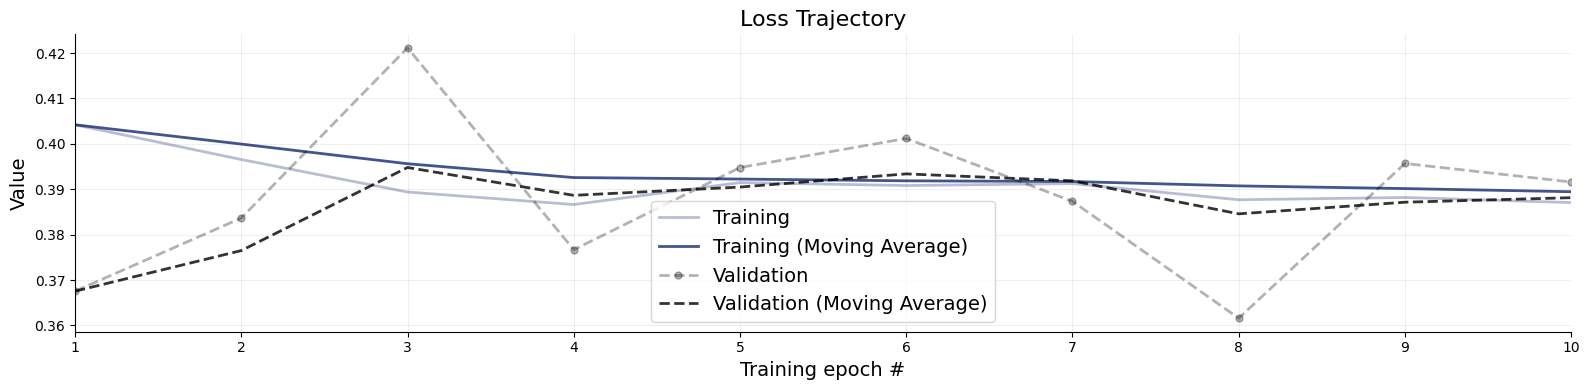

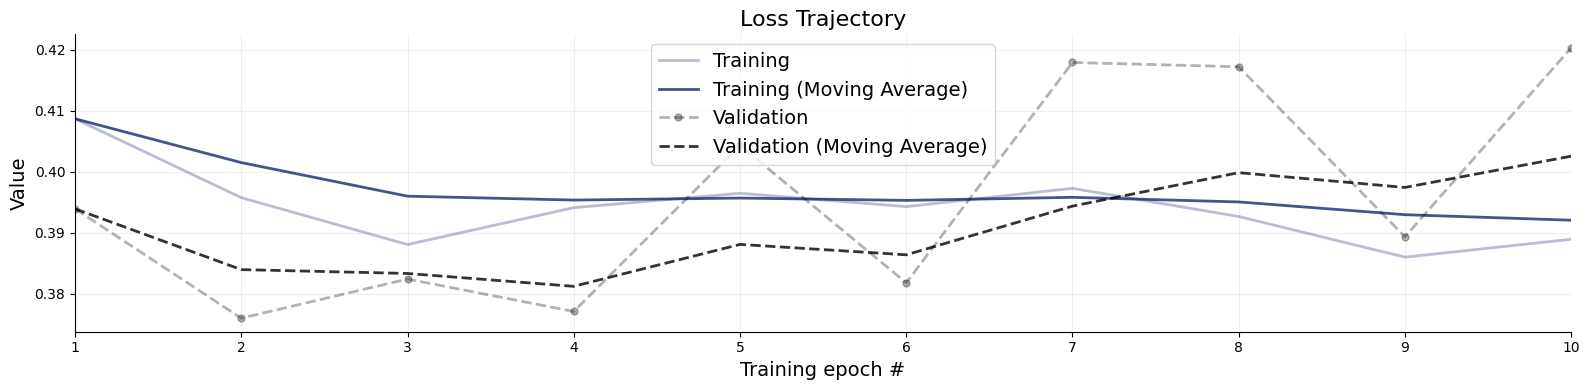

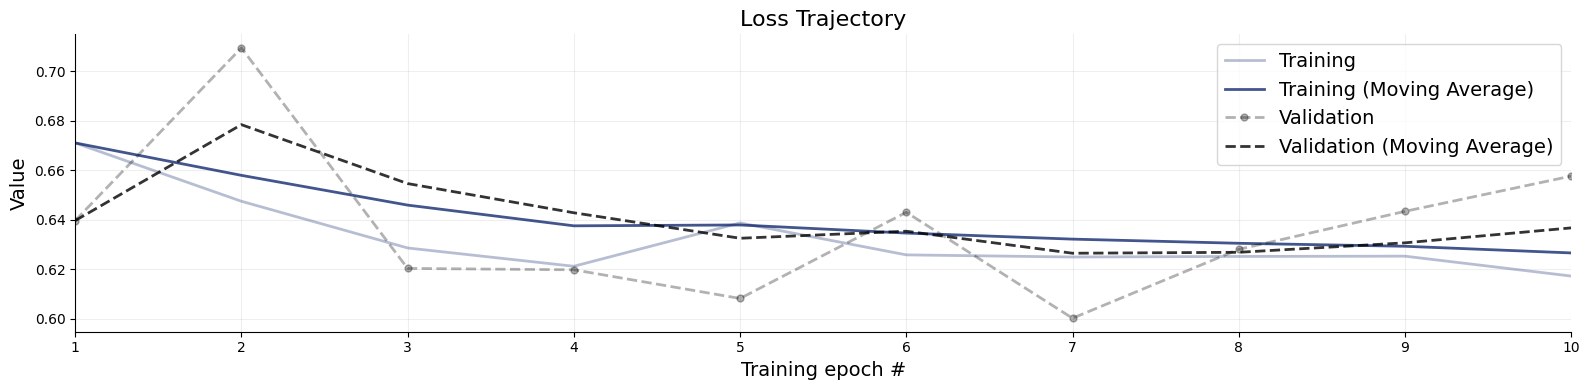

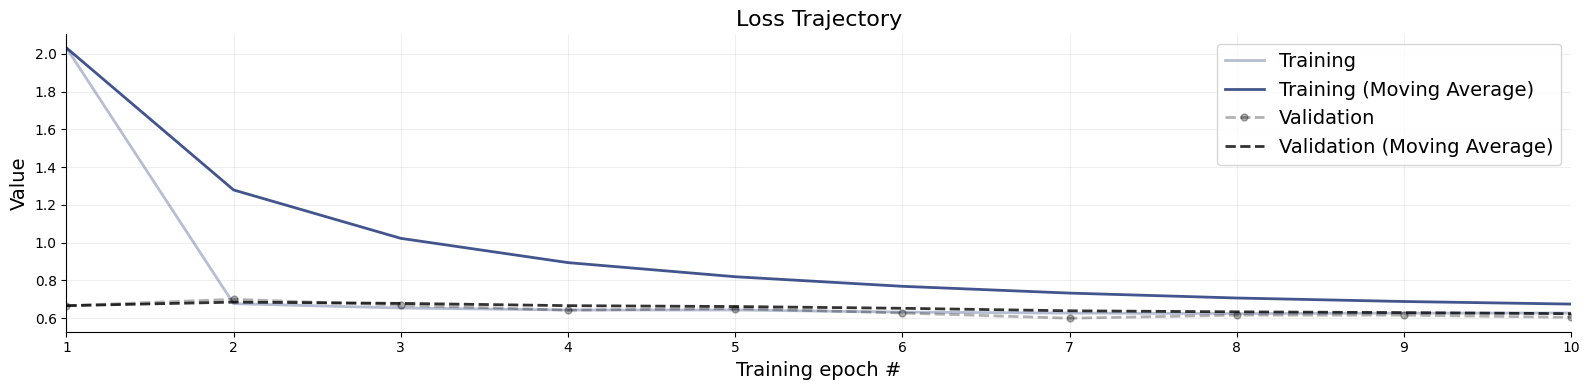

In [87]:
f_log = bf.diagnostics.plots.loss(history=history_log)

f_ce = bf.diagnostics.plots.loss(history=history_ce)

f_exp = bf.diagnostics.plots.loss(history=history_exp)

f_alpha_exp_log = bf.diagnostics.plots.loss(history=history_alpha_exp_log)